<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/2/MLP_NN_ModelEvaluationa%26Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
plt.style.use('seaborn-talk')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

import requests
import io

## GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12595709893173969491, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9354519784565611070
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

tf.config.experimental.set_memory_growth(gpus[0] , True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data: Farsi Hand-written digits classification

In [5]:
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Data/Farsi_digits_X.npz'
s=requests.get(url, stream=True).content
X = np.load(io.BytesIO(s) )['arr_0']
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Data/Farsi_digits_Y.npz'
s=requests.get(url, stream=True).content
Y = np.load(io.BytesIO(s) )['arr_0']

# X = np.load('X.npz')['arr_0']
# Y = np.load('Y.npz')['arr_0']


from sklearn.utils import shuffle
X, Y = shuffle(X,Y, random_state = 0 )

In [6]:
print('Each image is of the form: {}'.format(X[0].shape ) )

Each image is of the form: (32, 32)


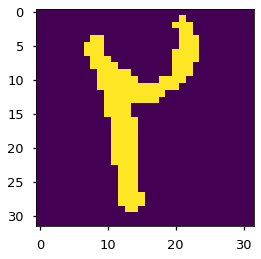

In [7]:
plt.imshow(X[20])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

## Pytorch

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 120)  
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        output = F.log_softmax(x, dim=1)

        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


In [11]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999))

tensor([[-2.2430, -2.2526, -2.1602, -2.3981, -2.2462, -2.3054, -2.3571, -2.2598,
         -2.5700, -2.2883]], grad_fn=<LogSoftmaxBackward>)


In [12]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

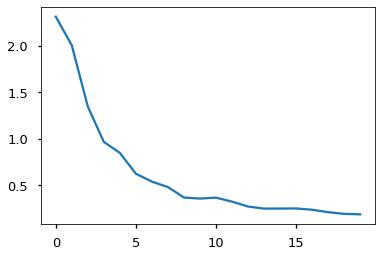

In [13]:
epochs = 20

#We also need to keep track of the loss. 
losses = []

for i in range(epochs):
    #Clear the previous gradients
    optimizer.zero_grad()
    
    #Precit the output for Given input
    y_pred = net.forward(x_tr)
    
    loss = F.nll_loss(y_pred, y_tr)
    losses += [loss]


    loss.backward()
    optimizer.step()
    
    
plt.plot(losses)
plt.show()

This sample is a 9.



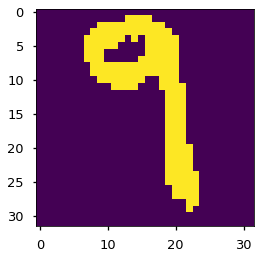

In [31]:
ind = 100
plt.imshow(x_ts[ind] )
pred = net.forward(x_ts[ind].view(-1,32,32)).argmax()
print(f'This sample is a {pred}.\n')

Let's add mini-batch optimization and keep track of the accuracy.

In [32]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999))
np.random.permutation(4)

array([0, 2, 1, 3])

In [33]:
epochs = 5
batch_size = 500
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss. 
sample_rate = 200
training_losses = []
val_losses = []

training_accuracy = []
val_accuracy = []

for i in range(epochs):
  permutation = np.random.permutation( n_s )  
  for j in range( 0, n_s , batch_size ):
    #Clear the previous gradients
    optimizer.zero_grad()

    ## Making the mini batches of data.
    ind = permutation[j:j+batch_size]
    X_batch, Y_batch = x_tr[ind], y_tr[ind]

    
    #Precit the output for Given input
    y_pred = net.forward(X_batch)
    
    loss = F.nll_loss(y_pred, Y_batch)
    loss.backward()
    optimizer.step()

    ## Every sample_rate, we record the loss and accuracy. 
    if j%(batch_size*sample_rate)==0:
      y_tr_pred = net.forward(x_tr)
      training_losses += [F.nll_loss( y_tr_pred, y_tr) ]
      training_accuracy += [torch.sum( y_tr == 
                                      torch.argmax( y_tr_pred, axis=1 ) ).numpy()/n_s ]

      # print(F.nll_loss( net.forward(x_ts) , y_ts) )
      y_ts_pred = net.forward(x_ts)
      val_losses += [F.nll_loss( y_ts_pred, y_ts) ]
      val_accuracy += [torch.sum( y_ts == 
                                      torch.argmax( y_ts_pred, axis=1 )).numpy()/n_ts ]



#  torch.cuda.empty_cache()    
    

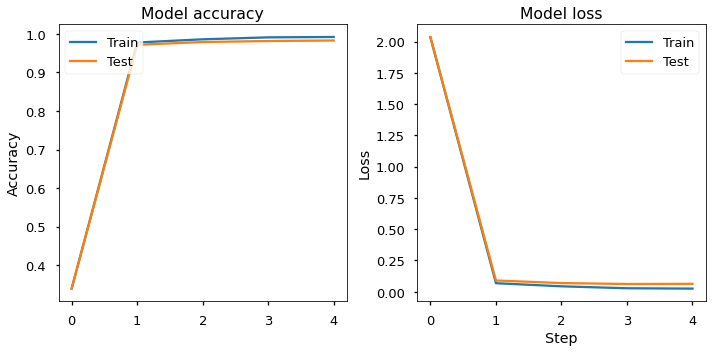

In [34]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(val_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(val_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()

## Keras

In [35]:
import tensorflow as tf
from tensorflow import keras

In [36]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

In [37]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
history = model.fit(X_train,Y_train, validation_split=0.25, epochs=5, batch_size=500)

Epoch 1/5
116/116 [==============================] - 4s 5ms/step - loss: 0.6811 - accuracy: 0.8075 - val_loss: 0.1655 - val_accuracy: 0.9547
Epoch 2/5
116/116 [==============================] - 0s 4ms/step - loss: 0.1458 - accuracy: 0.9598 - val_loss: 0.1223 - val_accuracy: 0.9665
Epoch 3/5
116/116 [==============================] - 0s 4ms/step - loss: 0.0997 - accuracy: 0.9729 - val_loss: 0.1015 - val_accuracy: 0.9709
Epoch 4/5
116/116 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9784 - val_loss: 0.0853 - val_accuracy: 0.9750
Epoch 5/5
116/116 [==============================] - 0s 4ms/step - loss: 0.0617 - accuracy: 0.9840 - val_loss: 0.0840 - val_accuracy: 0.9743


In [39]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(Y_test, Y_predicted)
print(cm)

[[2515    0    2    0    0   16    1    1    1    0]
 [   2 2497    6    0    1    0    2    0    1    2]
 [   4   13 2441   10    9    0   10    3    0   10]
 [   1    0  129 2335   73    3    2    0    0    1]
 [   2    8   36   30 2575   18    7    6    2    8]
 [   6    1    2    1    5 2473    1    1    6    1]
 [   1    5   19    0    6    1 2520    7    2   47]
 [   6    4    8    0    3    5    3 2579    0    0]
 [   3    5    0    1    1    3    4    1 2512   18]
 [   0   13    3    0    2    0   13    0    7 2506]]


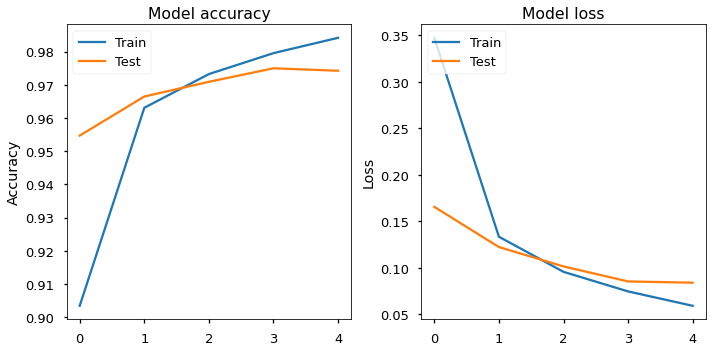

In [40]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [41]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

## We need to change the loss function for the one-hot encoding
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(X_train,Y_train, validation_split=0.25, epochs=50, batch_size=500, verbose=1)

Epoch 1/50
116/116 [==============================] - 1s 6ms/step - loss: 0.6594 - accuracy: 0.8112 - val_loss: 0.1632 - val_accuracy: 0.9563
Epoch 2/50
116/116 [==============================] - 1s 4ms/step - loss: 0.1406 - accuracy: 0.9616 - val_loss: 0.1221 - val_accuracy: 0.9667
Epoch 3/50
116/116 [==============================] - 1s 5ms/step - loss: 0.0990 - accuracy: 0.9723 - val_loss: 0.1003 - val_accuracy: 0.9720
Epoch 4/50
116/116 [==============================] - 1s 5ms/step - loss: 0.0756 - accuracy: 0.9786 - val_loss: 0.0861 - val_accuracy: 0.9755
Epoch 5/50
116/116 [==============================] - 1s 4ms/step - loss: 0.0613 - accuracy: 0.9832 - val_loss: 0.0795 - val_accuracy: 0.9773
Epoch 6/50
116/116 [==============================] - 1s 4ms/step - loss: 0.0493 - accuracy: 0.9880 - val_loss: 0.0707 - val_accuracy: 0.9792
Epoch 7/50
116/116 [==============================] - 1s 4ms/step - loss: 0.0409 - accuracy: 0.9895 - val_loss: 0.0657 - val_accuracy: 0.9808
Epoch 

In [43]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
print(cm)


[[2520    0    0    0    0   15    0    1    0    0]
 [   1 2499    4    0    3    0    1    0    0    3]
 [   2    6 2442   30    8    0    5    6    0    1]
 [   1    0   42 2474   25    2    0    0    0    0]
 [   2    8   14   38 2610    8    6    3    2    1]
 [   5    2    1    3    5 2470    2    1    6    2]
 [   2    6    4    0    3    1 2573    3    1   15]
 [   4    3    2    1    3    4    2 2589    0    0]
 [   2    5    0    1    1    3    3    1 2519   13]
 [   0   11    1    0    0    0   15    0    6 2511]]


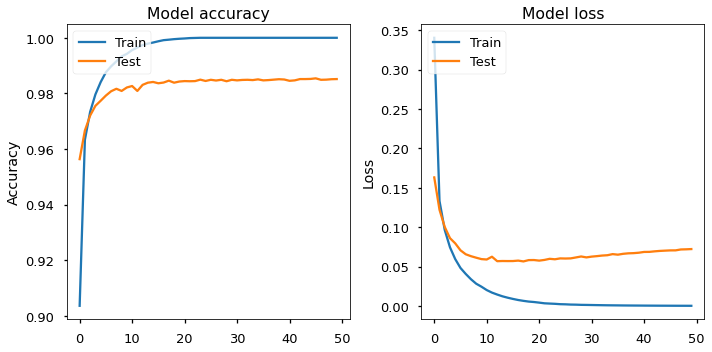

In [44]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Handling Overfitting


In [45]:
n_s = 100000
model.reset_states()
history_ovfit = model.fit(X_train[:n_s],Y_train[:n_s], 
#                           validation_split=0.05,
                          validation_data = (X_test, Y_test),
                          epochs=10 , 
                          batch_size=256, 
                          verbose=1)

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0421 - accuracy: 0.9891 - val_loss: 0.0662 - val_accuracy: 0.9839
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 0.0591 - val_accuracy: 0.9859
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.0589 - val_accuracy: 0.9860
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0587 - val_accuracy: 0.9868
Epoch 5/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0562 - val_accuracy: 0.9875
Epoch 6/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0573 - val_accuracy: 0.9874
Epoch 7/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.0585 - val_accuracy: 0.9871
Epoch 

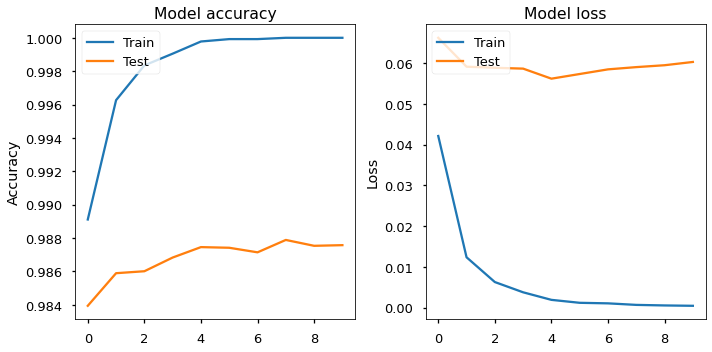

In [46]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit.history['accuracy'])
plt.plot(history_ovfit.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit.history['loss'])
plt.plot(history_ovfit.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)


In [59]:
model_ovfit1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1) ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1)),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_ovfit1.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_ovfit1.build([None, 2])
model_ovfit1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


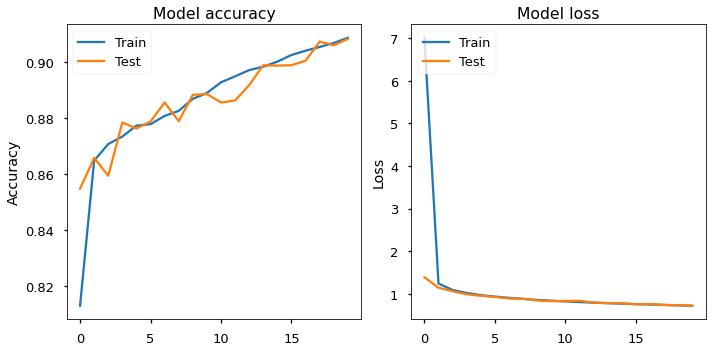

In [60]:
n_s = 1000000
history_ovfit1 =  model_ovfit1.fit(X_train[:n_s],Y_train[:n_s], 
#                           validation_split=0.05,
                          validation_data = (X_test, Y_test),
                          epochs=20 , 
                          batch_size=256, 
                          verbose=0)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit1.history['accuracy'])
plt.plot(history_ovfit1.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit1.history['loss'])
plt.plot(history_ovfit1.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [61]:
print(np.argmax(Y_test[:3],axis=1))
model_ovfit1.predict(X_test[:3]).argmax(axis=1)


[1 8 6]


array([1, 8, 6])

Epoch 1/20
300/300 [==============================] - 2s 5ms/step - loss: 1.1514 - accuracy: 0.6099 - val_loss: 0.1574 - val_accuracy: 0.9555
Epoch 2/20
300/300 [==============================] - 1s 4ms/step - loss: 0.2543 - accuracy: 0.9302 - val_loss: 0.1150 - val_accuracy: 0.9672
Epoch 3/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1964 - accuracy: 0.9467 - val_loss: 0.0967 - val_accuracy: 0.9722
Epoch 4/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1510 - accuracy: 0.9571 - val_loss: 0.0906 - val_accuracy: 0.9757
Epoch 5/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1389 - accuracy: 0.9602 - val_loss: 0.0824 - val_accuracy: 0.9771
Epoch 6/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1330 - accuracy: 0.9630 - val_loss: 0.0804 - val_accuracy: 0.9779
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1204 - accuracy: 0.9662 - val_loss: 0.0750 - val_accuracy: 0.9797
Epoch 

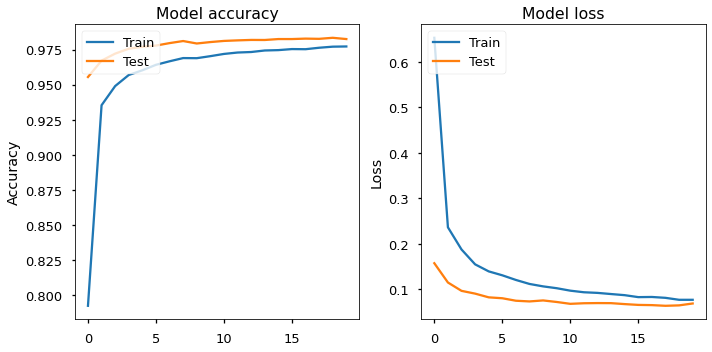

In [62]:
model_ovfit2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


model_ovfit2.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ovfit2 = model_ovfit2.fit(X_train[:n_s],Y_train[:n_s], 
                                  validation_data = (X_test, Y_test),
#                                   validation_split=0.05, 
                                  epochs=20 , 
                                  batch_size=256, verbose=1)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit2.history['accuracy'])
plt.plot(history_ovfit2.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit2.history['loss'])
plt.plot(history_ovfit2.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

***Assignment*** Play with these models and their hyperparameters to get a sense of how they affect the NN.

## Full Pipeline

### Cross-Validation

In [63]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [64]:
def model_fn():
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1) ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [65]:
epch = 10
batch_sz = 500

from sklearn.model_selection import KFold
n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True)


loss = []
acc = []
val_loss = []
val_acc = []

# cross validate:
for train_index, val_index in kf.split(X):
    model = model_fn()
    hist = model.fit(X[train_index], Y[train_index],
                     epochs=epch,
                     batch_size=500,
                     validation_data = (X[val_index], Y[val_index]),
                     verbose=0)
    loss.append(hist.history['loss'])
    acc.append(hist.history['accuracy'])
    val_loss.append([hist.history['val_loss']])
    val_acc.append(hist.history['val_accuracy'])
    
loss = np.array(loss).reshape(n_folds, epch )    
acc = np.array(acc).reshape(n_folds, epch )       
val_loss = np.array(val_loss).reshape(n_folds, epch )      
val_acc  = np.array(val_acc).reshape(n_folds, epch )       

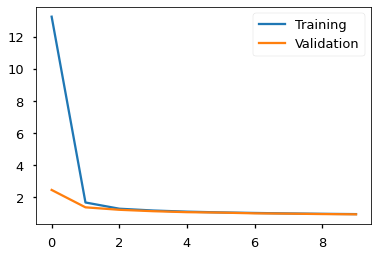

In [66]:
loss_m = loss.mean(axis=0)
loss_s = loss.var(axis=0)


val_loss_m = val_loss.mean(axis=0)
val_loss_s = val_loss.var(axis=0)

plt.plot(loss_m, label = 'Training')
plt.fill_between(range(len(loss_m)),loss_m-loss_s/2, loss_m+loss_s/2)
plt.plot(val_loss_m, label = 'Validation')
plt.fill_between(range(len(loss_m)),val_loss_m-loss_s/2, val_loss_m+loss_s/2)
plt.legend(loc=0)
plt.show()

In [67]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
results = cross_val_score(ks_model, X, Y, cv=kfold)
print(results.mean())

185/185 [==============================] - 1s 3ms/step - loss: 1.0863 - accuracy: 0.8747
Epoch 5/10
185/185 [==============================] - 1s 3ms/step - loss: 1.0307 - accuracy: 0.8774
Epoch 6/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9866 - accuracy: 0.8791
Epoch 7/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9589 - accuracy: 0.8792
Epoch 8/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9314 - accuracy: 0.8814
Epoch 9/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9105 - accuracy: 0.8828
Epoch 10/10
21/21 [==============================] - 0s 3ms/step - loss: 0.8872 - accuracy: 0.8837
Epoch 1/10
185/185 [==============================] - 1s 3ms/step - loss: 21.7063 - accuracy: 0.6687
Epoch 2/10
185/185 [==============================] - 1s 3ms/step - loss: 1.5076 - accuracy: 0.8679
Epoch 3/10
185/185 [==============================] - 1s 3ms/step - loss: 1.2157 - accuracy: 0.8791
Epoch 4/10


In [68]:
results

array([0.88100821, 0.89292693, 0.89057159, 0.90327311, 0.89643383,
       0.88754272, 0.90239376, 0.88617492, 0.88373232, 0.88998532])

In [72]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

csv_logger = CSVLogger('training.log', append=True)
calls=[csv_logger, EarlyStopping( patience=10), ModelCheckpoint('model_log', monitor='acc', save_best_only=True, mode='auto')]


In [73]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=0  )
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0 )
results = cross_val_score(ks_model, X, Y, cv=kfold,
                      fit_params = {'callbacks': calls})
print(results.mean())


0.8944719632466634


In [74]:
import pandas as pd
df = pd.read_csv('training.log')
df.groupby('epoch').mean()

,accuracy,loss
epoch,,
0,0.782080,13.249882
1,0.867118,1.668942
2,0.874416,1.277532
3,0.878708,1.164508
4,0.881251,1.095763
5,0.882750,1.047852
6,0.883016,1.012776
7,0.885239,0.984225
8,0.887276,0.959125


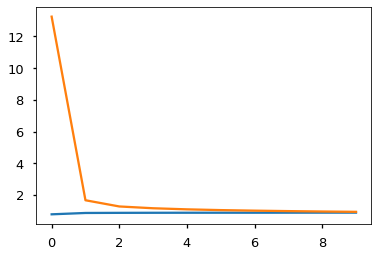

In [75]:
plt.plot(df.groupby('epoch').mean())

### Tuning

In [76]:
def model_fn(dense_layer_sizes, regularizations, dropouts, lr=.1):
    model = keras.Sequential() 
    
    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )
    
    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i], 
                                      activation=tf.nn.relu, 
                                      kernel_regularizer=keras.regularizers.l2(regularizations[i]) 
                                     ) )
        model.add(keras.layers.Dropout( dropouts[i] ) )
        
       
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
        
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
    

    return model

mdl = model_fn([100, 30], [.001, .001], [.001, .001], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 100)               102500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 30)                3030      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
_______________________________________________

In [80]:
def model_fn(dense_layer_sizes, lr=.1):
    model = keras.Sequential() 
    
    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )
    
    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i], 
                                      activation=tf.nn.relu #, 
                                      # kernel_regularizer=keras.regularizers.l2(regularizations[i]) 
                                     ) )
        # model.add(keras.layers.Dropout( dropouts[i] ) )
        
       
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
        
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
    

    return model

mdl = model_fn([100, 30], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 100)               102500    
_________________________________________________________________
dense_107 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_108 (Dense)            (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
_________________________________________________________________


In [81]:
Y_train.shape

(76764, 10)

In [82]:
btch_size = 500
epch = 3
history = mdl.fit(X_train, Y_train, batch_size=btch_size, epochs=epch )

Epoch 1/3
154/154 [==============================] - 1s 3ms/step - loss: 3.0966 - accuracy: 0.2302
Epoch 2/3
154/154 [==============================] - 1s 3ms/step - loss: 1.4589 - accuracy: 0.3688
Epoch 3/3
154/154 [==============================] - 1s 3ms/step - loss: 1.4039 - accuracy: 0.4468


In [83]:
# Grid search over these:
dense_size_candidates = [(10, 40), (50) , (20) ]
# regularizations_candidates = [ (.01), (.01), (.001) ]
# dropouts_candidates = [  (.005), (.01), (.003) ]
lr_candidates = [.1]
# epch_list = [4, 10]
batch_size_candidates = 500

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
# from sklearn.model_selection import 

gs_classifier = KerasClassifier(model_fn, batch_size=500, epochs=5)


In [84]:
validator = GridSearchCV(gs_classifier,
                         param_grid={'dense_layer_sizes': dense_size_candidates,
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [3],
                                    #  'regularizations': regularizations_candidates,
                                    #  'dropouts': dropouts_candidates,
                                     'lr': lr_candidates},
                         scoring='neg_log_loss',
                         n_jobs= 1,  )
validator.fit(X_train, Y_train)

Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.1302 - accuracy: 0.2106
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.5675 - accuracy: 0.3712
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 1.4028 - accuracy: 0.4360
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.4252 - accuracy: 0.1331
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 2.0549 - accuracy: 0.1869
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 2.0436 - accuracy: 0.1891
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.1963 - accuracy: 0.2215
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.4566 - accuracy: 0.3992
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 1.3532 - accuracy: 0.4463
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 1.7422 - accuracy: 0.3871
Epoch 2/3


GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f23a84c2ed0>,
             iid='deprecated', n_jobs=1,
             param_grid={'dense_layer_sizes': [(10, 40), 50, 20], 'epochs': [3],
                         'lr': [0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [85]:
print('The parameters of the best model are: ')
print(validator.best_params_)

# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = validator.best_estimator_.model

The parameters of the best model are: 
{'dense_layer_sizes': (10, 40), 'epochs': 3, 'lr': 0.1}


In [86]:
best_model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


## Try this for the particle identification problem.

In [ ]:
import pandas as pd
url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )
 
'''
Alternatively, you can download the file into your computer and run the following code. 
You need to uncomment it first. 
'''    

# data = pd.read_csv('particle-identification-from-detector-responses.zip', compression='zip')
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [ ]:
n_s = len(data)
targets = list(set(data['id']))
# mini_data = data.sample(n_s, axis=0, random_state=0)
# data['target'] = data['id'].apply(lambda x: targets.index(x)) 
data['id'] = pd.Categorical(data.id)
# data.drop('id',axis=1, inplace=True)

data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [ ]:
from sklearn.model_selection import train_test_split
Y_oh = keras.utils.to_categorical(data.id.cat.codes, num_classes=4, dtype=int)
ind_to_keep = ['p', 'beta']
X = data[ind_to_keep].values

X_train, X_test, Y_train, Y_test = train_test_split( data[ind_to_keep], Y_oh, random_state=0)

In [ ]:
Y_train.shape

(3750000, 4)